In [1]:
__author__='Xia Wang'
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import geopandas as gpd
import mplleaflet
import matplotlib.pyplot as plt
import os
import json
import statsmodels.formula.api as smf
import sklearn.cluster
import pysal

url = ("https://raw.githubusercontent.com"
       "/Elixeus/PUI2015_xwang/master/plotstyle.json")
response = urllib.urlopen(url)
s = json.loads(response.read())
plt.rcParams.update(s)

%matplotlib inline

SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

/Users/eliseowang/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

## Task 1

## Find the top 5 facilities using SQL query

In [3]:
dischargeQuery = '''
SELECT facility_id, ccs_diagnosis_description,
COUNT (*) AS patient_count
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description = 'ASTHMA'
GROUP BY facility_id, ccs_diagnosis_description
ORDER BY patient_count DESC
LIMIT 5
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)
discharge.head()

,facility_id,ccs_diagnosis_description,patient_count
0,1172,ASTHMA,1878
1,1169,ASTHMA,1786
2,1301,ASTHMA,1057
3,1165,ASTHMA,920
4,1178,ASTHMA,890


In [4]:
facilityQuery = '''
SELECT *
FROM nyc_facilities
'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData = json.loads(facilityStream.read())
facilities = gpd.GeoDataFrame.from_features(facilityData['features'],
                                            crs = {'init': 'epsg:4326', 
                                                   'no_defs': False})
#facilities.head()

In [5]:
# I'm taking the facility zip code here to facilitate task 2
facilities_s = facilities[['facility_id', 'facility_name',
                           'geometry','facility_zip_code',]]

## merge the id and the names

In [6]:
data1 = pd.merge(discharge, facilities_s, 
                 on = 'facility_id')
#type(data1)

In [7]:
# set initial coordinate reference system and change it to the New York State Plane
top5 = gpd.GeoDataFrame(data1, 
                        crs = {'init': 'epsg:4326',
                               'no_defs': False})
top5.to_crs(epsg=2263, inplace = True)

In [8]:
# prepare for task 2
top5['zipcode'] = top5['facility_zip_code']

## The top 5 facilities names are shown below in the table:

In [9]:
top5[['facility_name', 'patient_count']]

,facility_name,patient_count
0,Lincoln Medical & Mental Health Center,1878
1,Montefiore Medical Center - Henry & Lucy Moses...,1786
2,Kings County Hospital Center,1057
3,Jacobi Medical Center,920
4,Bronx-Lebanon Hospital Center - Concourse Divi...,890


In [10]:
#top5.ix[0,'geometry'].x

In [11]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
#zipcodes.head()

In [12]:
# change coordinate reference system
zipcodes.crs = {'init': 'epsg:4326', 'no_defs': False}
zipcodes.to_crs(epsg=2263, inplace = True)

## And the Map is shown below:

In [13]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
zipcodes.plot(axes = ax, alpha = 0.0,
              column = 'zipcode', linewidth = 0.5)
for i in np.arange(len(top5.centroid)):
    plt.scatter(top5.ix[i,'geometry'].x, 
                top5.ix[i,'geometry'].y,
                axes = ax, alpha =1.0, s = 100,
                color = 'r', marker = '+',
                linewidth = 4)
#plt.title('Map of Five Hospitals', axes = ax, fontsize = 20)
mplleaflet.display(crs = zipcodes.crs, tiles = 'cartodb_positron')
# I wish I could use the cartodb dark matter basemap, but I don't know how to make it work.
# Have to make do with the cartodb positron.

/Users/eliseowang/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


## Task 2

In [14]:
# Since we already have the zip code for each facility,
# we only have to merge it with the zip data
data2 = pd.merge(top5.drop('geometry',axis = 1),
                 zipcodes, on = 'zipcode')
highways = gpd.GeoDataFrame(data2)

In [15]:
highways.drop(['ccs_diagnosis_description', 
               'cartodb_id'], 
              axis = 1, inplace = True)

In [16]:
#highways.head()

# the highway lengths are shown below

In [17]:
highways[['facility_name','patient_count','zipcode','highway_length',]]

,facility_name,patient_count,zipcode,highway_length
0,Lincoln Medical & Mental Health Center,1878,10451,7.914185
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467,19.172015
2,Kings County Hospital Center,1057,11203,2.212840
3,Jacobi Medical Center,920,10461,18.102258
4,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457,5.017199


# The Map colored according to the highway length is shown below:

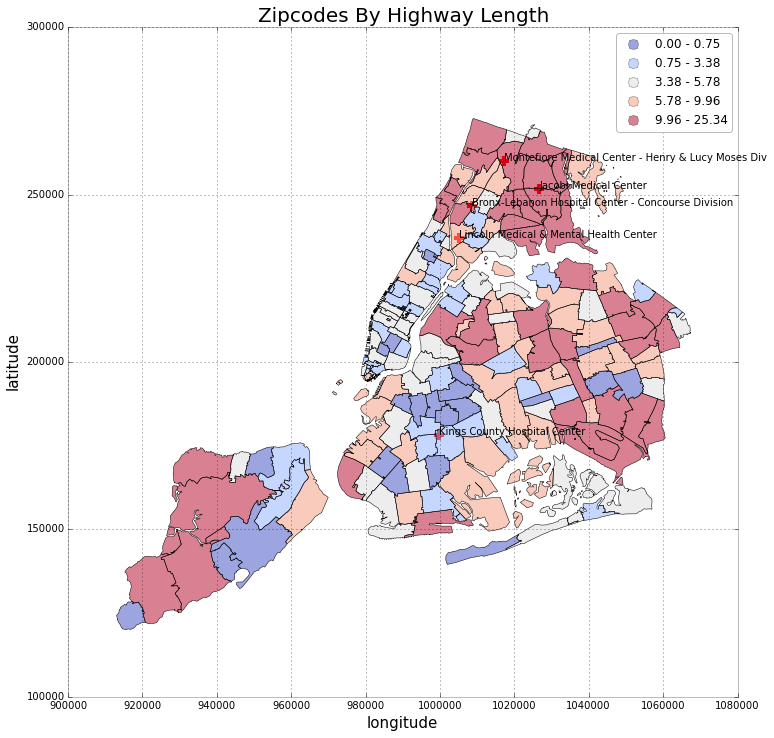

In [20]:
fig1 = plt.figure(figsize = (12,12))
ax1 = fig1.add_subplot(111)
for i in np.arange(len(top5.centroid)):
    plt.scatter(top5.ix[i,'geometry'].x, 
                top5.ix[i,'geometry'].y,
                axes = ax, alpha =1.0, s = 100,
                color = 'r', marker = '+',
                linewidth = 4)
    plt.annotate(top5.ix[i, 'facility_name'], xy = (top5.ix[i,'geometry'].x, 
                 top5.ix[i,'geometry'].y,), alpha = 1)
zipcodes.plot(axes = ax1, alpha = .5, linewidth = 0.5,
              edgecolor = 'k',column = 'highway_length', 
              colormap = 'coolwarm', scheme='Quantiles',
              legend = True)
plt.title('Zipcodes By Highway Length', 
          axes = ax1, fontsize = 20)
plt.xlabel('longitude',axes = ax1, fontsize = 15)
plt.ylabel('latitude',axes = ax1, fontsize = 15)
#ax1.set_axis_off()
# add color bar
#cbar = fig1.colorbar(zipcodes, ticks=[-1, 0, 1])
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
#mplleaflet.display(crs = zipcodes.crs)

## Task 3 Murder Rate (I will use 2013 data only)

In [19]:
precint_path = os.getenv('PUI2015')+'nypp.shp'
precint_path

'/Users/eliseowang/Documents/Principles/PUI_xwang/PUI2015_xwang/nypp.shp'

In [20]:
precincts = gpd.GeoDataFrame.from_file(precint_path)

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.



In [21]:
#precincts.head()

In [22]:
zip_path = (os.getenv('PUI2015')+
            'seven_major_felony_offenses_by_precinct_2000_2014.xls')
precinct_zip = pd.read_excel(zip_path, header = 1)
precinct_zip['Precinct'] = precinct_zip['PCT']

In [23]:
precinct_zip = precinct_zip[['Precinct',2013,'CRIME']]

In [24]:
pre_shape = gpd.GeoDataFrame(pd.merge(precinct_zip, 
                                      precincts, on = 'Precinct'))

In [25]:
#data3.drop(['PCT','CRIME'], axis =1, inplace = True)

In [26]:
#pre_shape.head()

In [27]:
asthma_zip = gpd.GeoDataFrame(
             pd.merge(top5[['facility_name',
                            'zipcode', 'patient_count']], 
                      zipcodes[['zipcode', 'geometry', 
                                'highway_length']], on = 'zipcode'))
#asthma_zip

In [28]:
def dist(zipcentroid, precinct_df, N):
    '''
This function is used to calculate the distance between one zipcode centroid
and precinct centroids and select the top N closest precincts. It returns a dataframe
of the top N precincts and their distance to the zipcode centroid.

zipcentroid: the centroid of the zipcode;
precinct_df: dataframe of the precincts;
N: how many precincts we want to return;
'''
    x = precinct_df
    x['distance'] = x['geometry'].apply(lambda j: 
                                        j.centroid.distance(zipcentroid))
    y = x.sort_values(by = 'distance', 
                      ascending = True).reset_index().iloc[:N,:]
    return y

In [29]:
# set the nearest precinct number to 3
num = 3

In [30]:
lincoln = dist(asthma_zip.geometry.centroid[0], 
               pre_shape, num)
montefiore = dist(asthma_zip.geometry.centroid[1], 
                  pre_shape, num)
kings = dist(asthma_zip.geometry.centroid[2], 
             pre_shape, num)
jacobi = dist(asthma_zip.geometry.centroid[3], 
              pre_shape, num)
bronx = dist(asthma_zip.geometry.centroid[4], 
             pre_shape, num)

In [31]:
lincoln['m_rate'] = lincoln[2013]/lincoln['distance']
montefiore['m_rate'] = montefiore[2013]/montefiore['distance']
kings['m_rate'] = kings[2013]/kings['distance']
jacobi['m_rate'] = jacobi[2013]/jacobi['distance']
bronx['m_rate'] = bronx[2013]/bronx['distance']

In [32]:
asthma_zip['exposure'] = None
asthma_zip['exposure'][0] = lincoln['m_rate'].sum()
asthma_zip['exposure'][1] = montefiore['m_rate'].sum()
asthma_zip['exposure'][2] = kings['m_rate'].sum()
asthma_zip['exposure'][3] = jacobi['m_rate'].sum()
asthma_zip['exposure'][4] = bronx['m_rate'].sum()

/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eliseowang/anacond

## For the murder exposure rate, I take the 3 nearest precincts for each zipcode, measure the distance , divide the number of murders of each precinct by its distance to the zipcode. The result is shown in the column 'exposure'

In [33]:
expo = zipcodes
expo['exposure'] = None

In [34]:
# calculate murder rate for each zipcode
for i in expo.index:
   expo['exposure'][i] = (dist(expo['geometry'].centroid[i], 
                               pre_shape, num)[2013]/
                          dist(expo['geometry'].centroid[i], 
                               pre_shape, num)['distance']).sum()
#expo.head()

/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Murder Rate table

In [35]:
asthma_zip.drop('geometry', axis = 1)

,facility_name,zipcode,patient_count,highway_length,exposure
0,Lincoln Medical & Mental Health Center,10451,1878,7.914185,0.00528943
1,Montefiore Medical Center - Henry & Lucy Moses...,10467,1786,19.172015,0.00370303
2,Kings County Hospital Center,11203,1057,2.212840,0.0229887
3,Jacobi Medical Center,10461,920,18.102258,0.00206549
4,Bronx-Lebanon Hospital Center - Concourse Divi...,10457,890,5.017199,0.00594838


## The choropleth map:

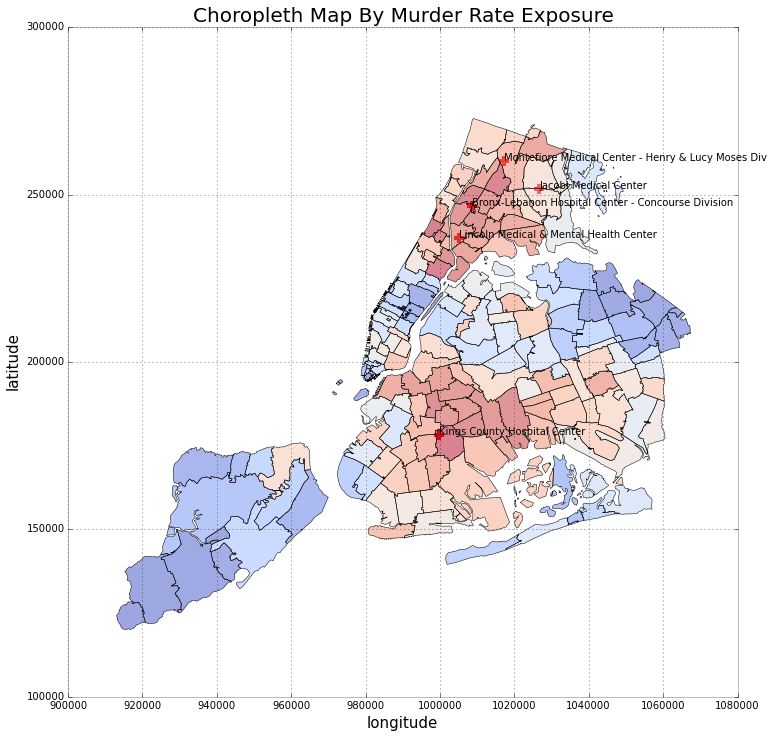

In [36]:
fig2 = plt.figure(figsize = (12,12))
ax2 = fig2.add_subplot(111)
for i in np.arange(len(top5.centroid)):
    plt.scatter(top5.ix[i,'geometry'].x, 
                top5.ix[i,'geometry'].y,
                axes = ax, alpha =1.0, s = 100,
                color = 'r', marker = '+',
                linewidth = 4)
    plt.annotate(top5.ix[i, 'facility_name'], xy = (top5.ix[i,'geometry'].x, 
                 top5.ix[i,'geometry'].y,), alpha = 1)
expo.plot(axes = ax2, alpha = .5, linewidth = 0.5,
          edgecolor = 'k', column = 'exposure', 
          colormap = 'coolwarm')
# expo.plot(axes = ax2, alpha = .5, scheme='jenks',
#           column = 'exposure', k = 5,
#           colormap = 'cool')
plt.title('Choropleth Map By Murder Rate Exposure', axes = ax2, fontsize = 20)
plt.xlabel('longitude',axes = ax2, fontsize = 15)
plt.ylabel('latitude',axes = ax2, fontsize = 15)
#ax2.set_axis_off()
#mplleaflet.display(crs = zipcodes.crs, tiles = 'cartodb_positron')

## Task 6 linear regression

## Normalize the data first

In [37]:
asthma_zip['patient_norm'] = asthma_zip['patient_count'].apply(
                                        lambda x: (x - asthma_zip['patient_count'].mean())
                                                   /asthma_zip['patient_count'].std())

In [38]:
asthma_zip['highway_norm'] = asthma_zip['highway_length'].apply(
                                        lambda x: (x - asthma_zip['highway_length'].mean())
                                                   /asthma_zip['highway_length'].std())

In [39]:
asthma_zip['exposure_norm'] = asthma_zip['exposure'].apply(
                                        lambda x: (x - asthma_zip['exposure'].mean())
                                                   /asthma_zip['exposure'].std())

## Run the Regression

In [40]:
lm = smf.ols(formula = 'patient_norm ~ highway_norm + exposure_norm - 1',
             data = {'patient_norm': asthma_zip.patient_norm,
                     'highway_norm': asthma_zip.highway_norm,
                     'exposure_norm': asthma_zip.exposure_norm}).fit()
lm.summary()

/Users/eliseowang/anaconda/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           patient_norm   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                 -0.531
Method:                 Least Squares   F-statistic:                    0.1334
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.880
Time:                        10:47:03   Log-Likelihood:                -6.3238
No. Observations:                   5   AIC:                             16.65
Df Residuals:                       3   BIC:                             15.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
highway_norm      0.1870      0.793      0.236      0.829        -2.337     2.711
exposure_norm    -0.1203      0.793     -0.152      0.889        -2.644     2.403
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.525
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.507
Skew:                           0.150   Prob(JB):                        0.776
Kurtosis:                       1.469   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Discussion: The regression result is not great. First of all, the $R^2$ is 0.082, meaning that only 8.2% of the variability of asthma rate is accounted by the two variables (highway length and the murder exposure rate). The p-value of the two coefficients are quite high, indicating they are not very reliable results. Also the confidence intevals range from negative to positive, again indicating the uncertainty of the regression model for the coefficients. Also worth mentioning is that the coefficient of the murder exposure. It is negative! That would mean the more one area is exposed to murder, the less asthma rate one area has. That is a little counterintuitive since we would assume high murder regions do worse in terms of sanitation.

##There might be some reasons for this negative coefficient, though. For example, it might simply because we only took 5 points to run the regression and there happen to be some outliers in these 5 points (King's County Hospital for example. Its zipcode doesn't have much highway, but there are a lot of asthma patients in this zipcode). Or it might be the way I exposure rate is not the best way. I calculated the distance using the centroid of both polygons. Maybe calculating the distance between the centroid of the precinct polygon and the nearest point of the zipcode polygon is a better way to do it.

## Also there might be other factors that affect asthma rate. And they are not incorporated into the model. Factors such as construction, parks can also cause asthma. A better linear model would take these factors into account as well, and use more datapoints as training set.

## Task 7 clustering and mapping

## Prepare the table for clustering

In [41]:
expo['highway_norm'] = expo['highway_length'].apply(
                                        lambda x: (x - expo['highway_length'].mean())
                                                   /expo['highway_length'].std())

In [42]:
expo['exposure_norm'] = expo['exposure'].apply(
                                        lambda x: (x - expo['exposure'].mean())
                                                   /expo['exposure'].std())

In [43]:
# weight the for all the zipcodes
clus = expo[['highway_norm', 'exposure_norm']]
clus['highway'] = clus['highway_norm']*lm.params[0]
clus['exposure'] = clus['exposure_norm']*lm.params[1]
clus.drop(['highway_norm','exposure_norm'], 
          axis = 1, inplace = True)

/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eliseowang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [44]:
clus.head()

,highway,exposure
0,0.584349,0.066746
1,-0.200730,0.066950
2,-0.152348,0.061089
3,-0.200730,0.070042
4,-0.200730,0.069171


## Since the two coefficients are of more or less the same scale, I'm not going to use log scale. I use k-means clustering method, k = 5.

In [45]:
# since the k-means clustering is a random process, let's seed it
# for the sake of reproducibility
np.random.seed(2015)
# set the number of clusters
n_c = 5
results = sklearn.cluster.k_means(clus, n_c)

In [46]:
expo['cluster'] = results[1]

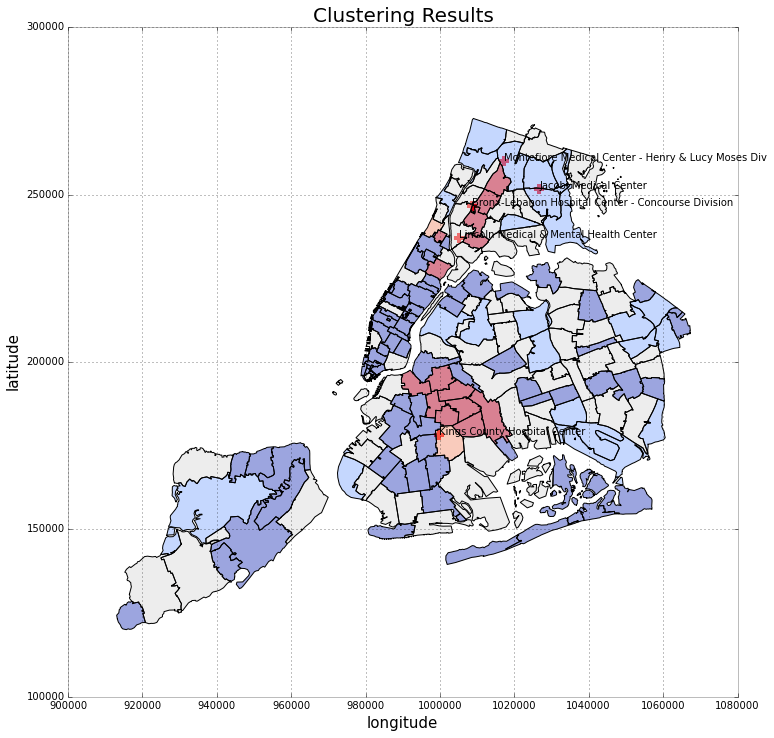

In [47]:
fig2 = plt.figure(figsize = (12,12))
ax2 = fig2.add_subplot(111)
for i in np.arange(len(top5.centroid)):
    plt.scatter(top5.ix[i,'geometry'].x, 
                top5.ix[i,'geometry'].y,
                axes = ax, alpha =1.0, s = 100,
                color = 'r', marker = '+',
                linewidth = 4)
    plt.annotate(top5.ix[i, 'facility_name'], xy = (top5.ix[i,'geometry'].x, 
                 top5.ix[i,'geometry'].y,), alpha = 1)
expo.plot(axes = ax2, alpha = .5, 
          column = 'cluster', colormap = 'coolwarm')
plt.title('Clustering Results', axes = ax2, fontsize = 20)
plt.xlabel('longitude',axes = ax2, fontsize = 15)
plt.ylabel('latitude',axes = ax2, fontsize = 15)
#mplleaflet.display(crs = zipcodes.crs)

## Discussion: 

## I'll start with the locations of the hospitals with more asthma patients. 4 of them are located in Bronx and 1 in Crown Heights, Brooklyn (where I live!). It might be that these areas are more susceptible to asthma. And the observation is actually backed up by the clustering results. We can see in the map the zipcodes around the hospitals do have a darker color. However, it is interesting to observe that only the Bronx-Lebanon Hospital Center is located in a high asthma rate zipcode. All other four are located in different clusters, but their corresponding zipcodes don't have an asthma rate as high as Bronx-Lebanon Hospital Center. This might also be due to the method I used to measure the distance, namely centroid to centroid.

## One other thing to notice in this map is that Mahattan in general share a similar pattern with some western part of Brooklyn and Long Island, probably because the highway length in these areas are quite low, and the murder rate is quite low as well. Using only these two factors and predictors, Manhattan and these areas in Brooklyn and Long Island should have relatively low asthma rate. Other areas are of a more mixed type and the pattern is more difficult to observe.

## In all, a linear model with more independent variables and using more data points as training set might be more accurate in predicting the asthma rate than the current one.